# Error Backpropagation (50 P)

In this programming exercise, we will experiment with backpropagation networks on a simple nonlinear two-dimensional classification dataset. In particular, we will try to find an explicit feature map in which the classification problem can be solved by a linear SVM. The gradient of the SVM objective with respect to its inputs will be backpropagated into the neural network in order to update the neural network parameters. The backbone implementation of the neural network is provided in the file `modules.py`.

## Backpropagating the Gradient of a SVM in a Neural Network

Let $x \to \phi(x;\theta)$ be a feature map implemented by a multilayer neural network, where $\theta$ is the set of all neural network parameters.

The L2 soft-margin SVM that operates on top of the neural network feature map representation learns a large-margin classification boundary that minimizes the objective given in unconstrained form as:
$$\qquad J = \frac1C ||w||^2 + \sum_{i=1}^n \max(0,1-y_i (w^\top \phi(x_i;\theta) + b))^2$$

where the SVM parameter $w$ is of same dimension as the feature map and where $b$ is a bias term. From this objective, we can derive the SVM gradient with respect to the feature map of a data point $x_i$ given as input:
$$\qquad \frac{\partial J}{\partial \phi(x_i;\theta)} = - 2 \max(0,1-y_i (w^\top \phi(x_i) + b)) \cdot y_i \cdot w$$

The gradient of the SVM is already implemented by `utils.LinearSVC` in the file `utils.py`. Once the SVM gradient is computed, we would like to backpropagate the gradient of the SVM into the neural network in order to update the parameters $\theta$. This is achieved by using the chain rule and computing the gradient:
$$\frac{\partial J}{\partial \theta} = \sum_i \frac{\partial \phi(x_i;\theta)}{\partial \theta} \cdot \frac{\partial J}{\partial \phi(x_i;\theta)}$$

## The `train()` Function

The following method learns a neural network representation on the 2D toy dataset provided in `datasets.py` by backpropagating the gradient of a SVC into the neural network and performing gradient descent. Note that at each iteration, a SVC classifier is optimized in order to get the most up-to-date gradient.

* At each `mstep`, the procedure prints the current value of the SVC objective when the the SVC is trained either on some training or test data. (Note that the neural network never sees the test data). The difference of SVC error on the training and test data gives a good idea of whether the representation learned by the neural network generalizes well on the test data.

* At each `vstep`, the procedure displays a visualization (`utils.visualize(...)`) of what has been learned by the neural network.

In [1]:
import datasets,numpy

def train(nn,svc,msteps=[],vsteps=[],lr=0.1):
    
    X,Y = datasets.toy()
    Xtest,Ytest = datasets.toy(test=True)
    
    # Train the neural network for 100 iterations
    for it in range(1,101):
        
        # Perform one step of gradient descent in the neural network
        Z = nn.forward(X)
        svc.optimize(Z,Y)
        DZ = svc.gradient()
        nn.backward(DZ)
        nn.update(lr)
    
        # Print current error
        if it in msteps:
            print('%4d J=%7.3f Jtest=%7.3f'%(it,svc.optimize(nn.forward(X),Y),svc.optimize(nn.forward(Xtest),Ytest)))
            
        # Visualize what has been learned
        if it in vsteps:
            Ztest = nn.forward(Xtest)
            svc.optimize(Ztest,Ytest)
            DZtest = svc.gradient()
            Ftest  = svc.predictions()
            DXtest = nn.backward(DZtest)
            utils.visualize(Xtest,DXtest,Ftest,Ytest)


## Linear Feature Map

In the code below, a particular neural network feature map is considered: a linear transformation (`modules.Linear`) followed by a linear neuron activation function (`modules.Identity`) that applies similarly to each 20 neurons. One can observe by running the code, that the 20-dimensional linear feature map does not allow for nonlinear classification. The rightmost plot shows the gradient of the objective $\partial J / \partial x_i$ with respect to each data point $x_1,\dots,x_n$ in the dataset. Points outside the margin have no SVC gradient (i.e. are on the right side of the SVM margin and do not influence the classifier). On the other hand, points that are inside the margin or on the opposite side have a non-zero gradient, as shown by the arrows.

   1 J=171.559 Jtest=158.002
  10 J=171.559 Jtest=158.002
 100 J=171.557 Jtest=157.999


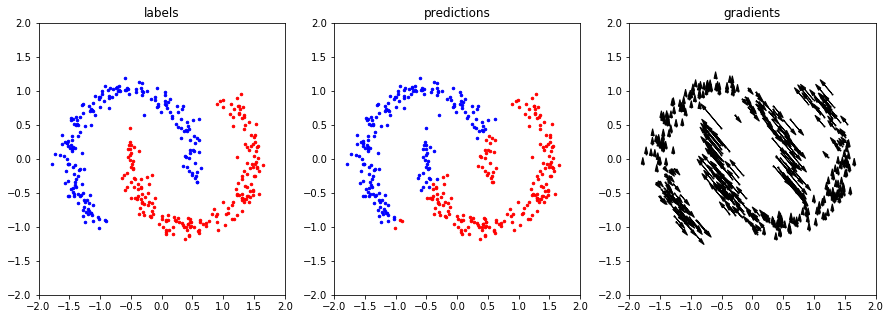

In [29]:
import modules,utils
%matplotlib inline

nn  = modules.Sequential([
    modules.Linear(2,30,seed=0),
    modules.Identity(),
])
svc = utils.LinearSVC(C=1.0)

train(nn,svc,msteps=[1,10,100],vsteps=[100])

## Part A: Adding Nonlinearity to the Feature Map (25 P)

In order to learn a nonlinear decision boundary that fits the dataset, we need to introduce nonlinearity into the feature map.

**Tasks:**

*  **Write a class `Sigmoid` that inherits `modules.Module` and implements a layer of sigmoid nonlinearity (as defined in the slides).**
*  **Keeping the dimensionality of the feature map to 20, replace the identity activation function of the neural network above by the sigmoid activation function that you have implemented.**
*  **Run the code, and compare the value of the SVM objective to the one obtained with the linear network.**
*  **Give an interpretation of the resulting plots.**

   1 J= 97.784 Jtest= 96.386
  10 J= 44.730 Jtest= 41.743
 100 J= 19.232 Jtest= 18.602


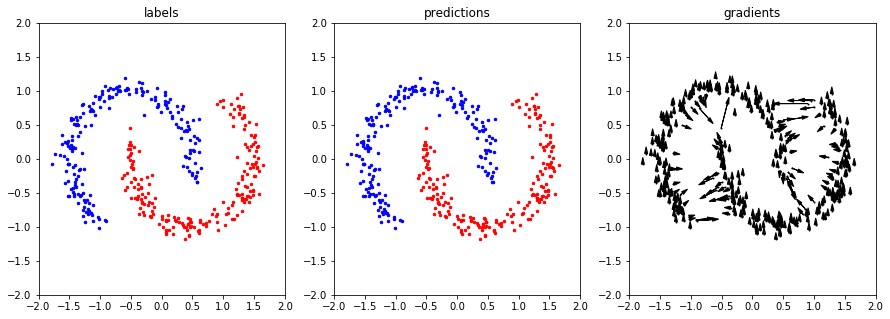

In [10]:
# import solutions
# %matplotlib inline
# solutions.A(train)
class Sigmoid(modules.Module):
    def forward(self,X):
#         m = numpy.ones(X.shape)
        self.Y = 1/(1+numpy.exp(-X))
        return self.Y
    def backward(self, DY):
        return DY*self.Y*(1-self.Y)

# Define network arcitecture
nn2  = modules.Sequential([
    # Layer with 2 input neurons to 20 hidden neurons
    modules.Linear(2,20,seed=0),
    Sigmoid(),
])

# Define support vector machine function
svc = utils.LinearSVC(C=1.0)

# Train using defined network arcitecture and svm
train(nn2,svc,msteps=[1,10,100],vsteps=[100])

## Part B: Adding More Layers (25 P)

One layer of nonlinearity might be enough to separate the data, but might not be sufficient in order to support a large-margin classifier. In this case, one can add a additional layer of nonlinearity to the neural network in order to increase its representational power.

**Tasks:**

* **Construct a network with *two* layers of sigmoid nonlinearity. The first layer of neurons has dimension 10 and the second layer has dimension 20.**
* **Run the code, and compare the value of the SVM objective to the one obtained when using only one layer of nonlinearity.**

   1 J=168.210 Jtest=154.767
  10 J= 25.971 Jtest= 24.008
 100 J=  7.010 Jtest=  6.765


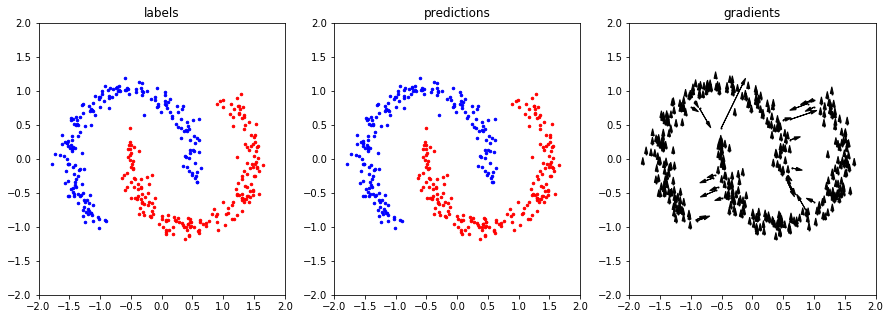

In [33]:
nn  = modules.Sequential([
    modules.Linear(2,30,seed=0),
    Sigmoid(),
    modules.Linear(30,40,seed=1),
    Sigmoid(),
])
svc = utils.LinearSVC(C=1.0)

train(nn,svc,msteps=[1,10,100],vsteps=[100])

**Tasks:**

* **Repeat the experiment for a network with *three* layers of sigmoid nonlinearity. The first layer of neurons has dimension 5, the second layer has dimension 10 and the third layer has dimension 20.**
* **Run the code, and compare the value of the SVM objective to the one obtained when using only one or two layers of nonlinearity.**

   1 J=197.087 Jtest=178.388
  10 J=134.175 Jtest=117.082
 100 J=  2.067 Jtest=  2.319


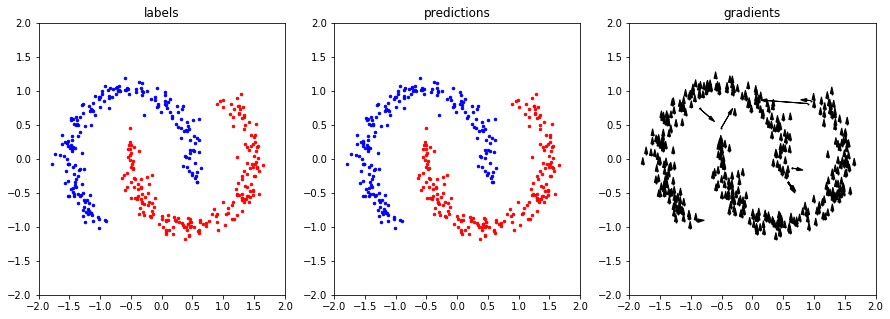

In [44]:
nn  = modules.Sequential([
    modules.Linear(2,5,seed=0),
    Sigmoid(),
    modules.Linear(5,10,seed=1),
    Sigmoid(),
    modules.Linear(10,20,seed=2),
    Sigmoid(),
])
svc = utils.LinearSVC(C=1.0)

train(nn,svc,msteps=[1,10,100],vsteps=[100])

In [62]:
import numpy as np
np.ones(2,int)+ 4

array([5, 5])